# Investigating collapse onto RL fine-tuning data distribution

-----

RL4LMT | Group Project

WiSe 2023/2024

-----

Authors: Marc Baumholz, Meike Kriegeskorte, Line Abele

Last Update: February 7, 2024

-----

## Project Description

We want to investigate ...

...

...


----

Link to Github: ...

Link to Report: ...

----

In [ ]:
# offene probleme / todos:

# section 1
# - habe das model nicht zum laden gekriegt
# OSError: Can't load tokenizer for 'CarperAI/openai_summarize_tldr_ppo'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure 'CarperAI/openai_summarize_tldr_ppo' is the correct path to a directory containing all relevant files for a GPT2TokenizerFast tokenizer.
# falscher name, falscher tokenizer, ...?

# section 3:
# - leider noch uncleaned prompts (satzzeichen, stopwords, ... alles noch mit drin))
# - sentiment_model() klappt für testset nicht, noch nicht herausgefunden warum
# - syntactic structure (wie most frequent SEQUENCES of POS rausziehen, z.b. S-V-O?), gerade speichere ich einfach nur alle POS in einer liste

# section 4:
# - hübschere plots
# - genauerer vergleich: (mis)matches der statistiken zwischen train/test, um es in section 5 und 6 zu nutzen

# section 5

# section 6

# section 7

## Work steps (given by Polina)

1. use the RL-LM summarization model CarperAI/openai_summarize_tldr_ppo, was trained following Stiennon et al. [2022] by Castricato et al. [2023].

2. use the fine-tuning train and test splits of the dataset CarperAI/openai_summarize_tldr which
contains Reddit posts which have to be summarized.

3. get information on the datasets with respect to the points above:
- sentence length distribution (POS can be retrieved with e.g. spacy)
- syntactic structure (approximated, e.g., by common sequences of POS tags) (POS can be retrieved with e.g. spacy)
- frequencies of different POS (spacy)
- frequencies of the lemmata (spacy)
- sentiment distribution of the texts (some pretrained model from HuggingFace could be used for that)

4. run descriptive stats on the information retrieved above (e.g., plot distributions, check if they match between train and test datasets).

5. generate predictions for the portion of the test split where the main statistics match the training statistics from the model (50 examples suffiecient). Annotate your intuitive quality judgement of the outputs. Get
reward model predictions for the outputs.

6. generate predictions for the portion of the test split where the main statistics MISmatch the training statistics from the model (50 examples sufficient). Annotate your intuitive quality judgement of the outputs. Get reward model predictions for the outputs.

7. compare the rewards and your own judgements. Does the model perform worse on the portion of the test split which is OOD relative to the train split?

## Preparations

In [ ]:
# imports
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import spacy
!pip install -U spacy-cleaner
import spacy_cleaner
from spacy_cleaner.processing import removers, replacers, mutators
import numpy as np
import pandas as ps
from collections import Counter

## 1 Summarization model

Use the RL-LM summarization model CarperAI/openai_summarize_tldr_ppo, was trained following Stiennon et al. [2022] by Castricato et al. [2023].

In [ ]:
# load pretrained tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("CarperAI/openai_summarize_tldr_ppo")
model = AutoModelForCausalLM.from_pretrained("CarperAI/openai_summarize_tldr_ppo")

OSError: Can't load tokenizer for 'CarperAI/openai_summarize_tldr_ppo'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure 'CarperAI/openai_summarize_tldr_ppo' is the correct path to a directory containing all relevant files for a GPT2TokenizerFast tokenizer.

got this error :/

OSError: Can't load tokenizer for 'CarperAI/openai_summarize_tldr_ppo'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure 'CarperAI/openai_summarize_tldr_ppo' is the correct path to a directory containing all relevant files for a GPT2TokenizerFast tokenizer.

## 2 Summarization dataset


Use the fine-tuning train and test splits of the dataset CarperAI/openai_summarize_tldr which contains Reddit posts which have to be summarized.

In [ ]:
# load the dataset
dataset = load_dataset("CarperAI/openai_summarize_tldr")
dataset

DatasetDict({
    train: Dataset({
        features: ['prompt', 'label'],
        num_rows: 116722
    })
    test: Dataset({
        features: ['prompt', 'label'],
        num_rows: 6553
    })
    valid: Dataset({
        features: ['prompt', 'label'],
        num_rows: 6447
    })
})

In [ ]:
# Example entry containing a prompt (title, post, backstory) and a label (summary)
dataset['train'][0]

{'prompt': "SUBREDDIT: r/relationships\nTITLE: I (f/22) have to figure out if I want to still know these girls or not and would hate to sound insulting\nPOST: Not sure if this belongs here but it's worth a try. \n\nBackstory:\nWhen I (f/22) went through my first real breakup 2 years ago because he needed space after a year of dating roand  it effected me more than I thought. It was a horrible time in my life due to living with my mother and finally having the chance to cut her out of my life. I can admit because of it was an emotional wreck and this guy was stable and didn't know how to deal with me. We ended by him avoiding for a month or so after going to a festival with my friends. When I think back I wish he just ended. So after he ended it added my depression I suffered but my friends helped me through it and I got rid of everything from him along with cutting contact. \n\nNow: Its been almost 3 years now and I've gotten better after counselling and mild anti depressants. My mothe

In [ ]:
train = dataset['train']
test = dataset['test']

## 3 Dataset information

Get information on the datasets with respect to the points above:

- sentence length distribution (POS can be retrieved with e.g. spacy)

- syntactic structure (approximated, e.g., by common sequences of POS tags) (POS can be retrieved with e.g. spacy)

INFO FROM WIKI:
In corpus linguistics, part-of-speech tagging (POS tagging or PoS tagging or POST), also called grammatical tagging is the process of marking up a word in a text (corpus) as corresponding to a particular part of speech,[1] based on both its definition and its context.
(e.g. marking a word as verb, noun, adjective, adverb, ...)

- frequencies of different POS (spacy)

- frequencies of the lemmata (spacy)

- sentiment distribution of the texts (some pretrained model from HuggingFace could be used for that)

In [ ]:
# only prompts, for faster computation I only worked with first 50 till now
prompts_train = train['prompt'][0:50]
prompts_test = test['prompt'][0:50]

In [ ]:
# cleaning the prompts

def normalize(text, remove_stopwords, remove_punctuation):
    # only small letters
    text = text.lower()

    text = nlp(text)
    lemmatized = list()

    for word in text:
        # remmove
        if remove_stopwords and word.is_stop:
            continue
        if remove_punctuation and word.is_punct:
            continue
        lemma = word.lemma_.strip()
        if lemma:
            lemmatized.append(lemma)
    return lemmatized


In [ ]:
# example cleaning
p = train['prompt'][3]
p1 = normalize(p, True, True)

print(p)
print("\n --------------------- \n")
print(p1)

SUBREDDIT: r/personalfinance
TITLE: Prioritize student debt or saving for down payment?
POST: I have $25k in student debt. One private loan at 9.5% (highest priority obviously) and nine others federal between 3.4% and 6.8%. Minimum payment per month total is $301.16. Over the next 9 months, I will pay off $11k of these, which will get rid of everything above 5% interest and will drop the total minimum payment to $150. 

At the end of the 9 months, our savings will be around $35k. At that time my husband will need to purchase a car so some of that will be his down payment. So more realistically $25-30k. 

Sometime in the future, between a year to two years from now, my husband and I may be moving. Typical single family homes in this area go for around $300k. 

At the end of the 9 months, should I continue to focus on paying down student debt (which will be a balance of $14k by then) or growing our savings/down payment? I have $5200/mo to somehow split between debt and down payment and I

In [ ]:
# sentiment distribution of the texts (some pretrained model from HuggingFace could be used for that)

# example
example_data = ["I love you", "I hate you"]
sentiment_model = pipeline(model="distilbert/distilbert-base-uncased-finetuned-sst-2-english")
sentiment_model(example_data)

[{'label': 'POSITIVE', 'score': 0.9998656511306763},
 {'label': 'NEGATIVE', 'score': 0.9991129040718079}]

In [ ]:
# Examples of language analysis with spacy (PROBLEM: need to be whole strings, not cleaned as with normalize()-function before)
# https://spacy.io/usage/linguistic-features

# load english
nlp = spacy.load("en_core_web_sm")

# example prompt
p = train['prompt'][3]

# normalize(p, remove_stopwords = True, remove_punctuation = True) (PROBLEM: need to be whole strings for sentence segm, not list with normalized lemmas)

# insert p in nlp
doc = nlp(p)

# segment sentences
for sent in doc.sents:
  print(sent.text)

print("\n --------------------- \n")

# print tokens (words), lemmatization of tokens (quasi wörterbucheintrag zum wort) and POS
for token in doc:
  print(token.text, token.lemma_, token.pos_)

print("\n --------------------- \n")

print(sentiment_model(p)[0]['score'])
print(sentiment_model(p)[0]['label'])

SUBREDDIT: r/personalfinance
TITLE: Prioritize student debt or saving for down payment?
POST: I have $25k in student debt.
One private loan at 9.5% (highest priority obviously) and nine others federal between 3.4% and 6.8%.
Minimum payment per month total is $301.16.
Over the next 9 months, I will pay off $11k of these, which will get rid of everything above 5% interest and will drop the total minimum payment to $150. 


At the end of the 9 months, our savings will be around $35k.
At that time my husband will need to purchase a car so some of that will be his down payment.
So more realistically $25-30k. 


Sometime in the future, between a year to two years from now, my husband and I may be moving.
Typical single family homes in this area go for around $300k. 


At the end of the 9 months, should I continue to focus on paying down student debt (which will be a balance of $14k by then) or growing our savings/down payment?
I have $5200/mo to somehow split between debt and down payment an

In [ ]:
# Function for Language anaylsis

# calculate average sentence length over all prompts in a data set (train, test)
def language_analyser(prompts):

  # list of sentence lengths filled by iterating over all prompts
  sent_len = []
  lemmas = []
  pos = []
  sentim_score = []
  sentim_label = []

  for p in prompts:
    # insert prompt
    doc = nlp(p)

    # segment sentences in prompt
    for sent in doc.sents:
      sent_len.append(len(sent.text)) # list of sentence lenghts in prompt p

    # tokenize the prompt, lemmatize it and ask for POS
    for token in doc:
      lemmas.append(token.lemma_)
      pos.append(token.pos_)

    # sentiment analysis
    sentim_score.append(sentiment_model(p)[0]['score'])
    sentim_label.append(sentiment_model(p)[0]['label'])

  return sent_len, lemmas, pos, sentim_score, sentim_label

In [ ]:
analysis_train = language_analyser(prompts_train)
analysis_test = language_analyser(prompts_test)

RuntimeError: The size of tensor a (516) must match the size of tensor b (512) at non-singleton dimension 1

### Sentence Length Distribution

In [ ]:
# Sentence Lengths

train_sent_length = analysis_train[0]
avg_sent_len_train = np.mean(train_sent_length)
print("Average Sentence length in Train Set:", avg_sent_len_train)

test_sent_length = analysis_test[0]
avg_sent_len_test = np.mean(test_sent_length)
print("Average Sentence length in Test Set:", avg_sent_len_test)

### Lemmata

In [ ]:
# frequencies of the lemmata

most_common_lemmas_train = Counter(analysis_train[1]).most_common(20)
print("Most common lemmata in train set:", most_common_lemmas_train)

most_common_lemmas_test = Counter(analysis_test[1]).most_common(20)
print("Most common lemmata in test set:", most_common_lemmas_test)

Most common lemmata in train set: [('I', 929), ('be', 759), ('.', 651), (',', 444), ('to', 439), ('and', 421), ('the', 343), ('a', 309), ('have', 286), ('my', 263), ('not', 230), (':', 227), ('she', 213), ('he', 197), ('of', 191), ('do', 173), ('it', 170), ('that', 167), ('\n', 163), ('\n\n', 159)]


NameError: name 'analysis_test' is not defined

### POS

In [ ]:
# frequencies of different POS

most_common_POS_train = Counter(analysis_train[2]).most_common(20)
print("Most common POS in train set:", most_common_POS_train)

most_common_POS_test = Counter(analysis_test[2]).most_common(20)
print("Most common POS in test set:", most_common_POS_test)

Most common POS in train set: [('PRON', 2561), ('NOUN', 2089), ('VERB', 1956), ('PUNCT', 1806), ('ADP', 1337), ('AUX', 1250), ('ADV', 1026), ('ADJ', 959), ('DET', 862), ('CCONJ', 631), ('PART', 568), ('SCONJ', 435), ('PROPN', 388), ('SPACE', 373), ('NUM', 217), ('SYM', 117), ('X', 86), ('INTJ', 25)]


NameError: name 'analysis_test' is not defined

### Syntactic Structure

In [ ]:
#  syntactic structure
# (approximated, e.g., by common sequences of POS tags)

# did not manage to find a quick way to find common sequences in the list of all POS (language_analyser(prompts_train)[2]) returned by the lanugage_analyser()

# get idea of how POS train looks like
pos_train = analysis_train[2]
pos_test = analysis_test[2]

NameError: name 'analysis_test' is not defined

### Sentiment Analysis

In [ ]:
sentim_score_train = analysis_train[3]
#sentim_score_test = analysis_test[3]

sentim_label_train = analysis_train[4]
#sentim_label_test = analysis_test[4]

In [ ]:
# Number of prompts with pos/neg sentiment label
Counter(sentim_label_train)
#Counter(sentim_label_test)

Counter({'NEGATIVE': 45, 'POSITIVE': 5})

In [ ]:
# Average sentiment score
avg_sentim_train = np.mean(sentim_score_train)
print("Average Sentiment Score in Train Set:", avg_sentim_train)
#avg_sentim_test = np.mean(sentim_score_test)
#print("Average Sentiment Score in Train Set:", avg_sentim_test)

Average Sentiment Score in Train Set: 0.9586806666851043


## 4 Descriptive stats

Run descriptive stats on the information retrieved above (e.g., plot distributions, check if they match between train and test datasets).

In [ ]:
## plot functions

def plot_dictionary_bar(dictionary):
  keys = dictionary.keys()
  values = dictionary.values()

  plt.bar(keys, values)
  plt.xlabel('Label')
  plt.ylabel('Score')
  plt.title('Dictionary Bar Chart')

  plt.show()

<BarContainer object of 2 artists>

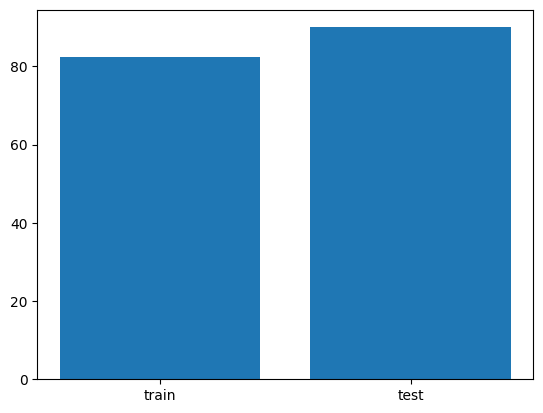

In [ ]:
# Sentence length

x = ['train', 'test']
y = [avg_sent_len_train, avg_sent_len_test] # !!!! avg_sent_len_test not finished yet

plt.bar(x, y)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'I'),
  Text(1, 0, 'be'),
  Text(2, 0, '.'),
  Text(3, 0, ','),
  Text(4, 0, 'to'),
  Text(5, 0, 'and'),
  Text(6, 0, 'the'),
  Text(7, 0, 'a'),
  Text(8, 0, 'have'),
  Text(9, 0, ':'),
  Text(10, 0, 'he'),
  Text(11, 0, 'she'),
  Text(12, 0, 'of'),
  Text(13, 0, 'my'),
  Text(14, 0, 'in'),
  Text(15, 0, 'not'),
  Text(16, 0, 'that'),
  Text(17, 0, '\n'),
  Text(18, 0, 'it'),
  Text(19, 0, 'do')])

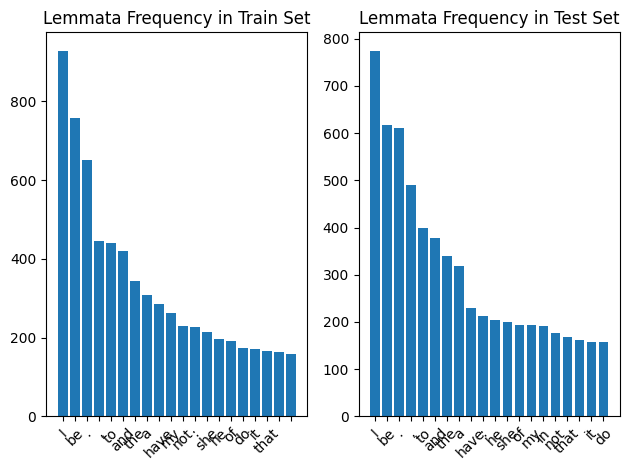

In [ ]:
# Lemmata frequency train
# --> hier wird klar, dass wir auf jeden fall noch den datensatz cleanen müssen: punctuation, stopwords, ...

y_train = [count for tag, count in most_common_lemmas_train]
x_train = [tag for tag, count in most_common_lemmas_train]

y_test = [count for tag, count in most_common_lemmas_test] # !!! alle test-data-werte stimmen noch nicht !!!
x_test = [tag for tag, count in most_common_lemmas_test] # !!! alle test-data-werte stimmen noch nicht !!!

plt.subplot(121)  #sublot(Anzahl Zeilen Anzahl Spalten Bild Nummer)
plt.bar(x_train, y_train)
plt.title("Lemmata Frequency in Train Set")
plt.tight_layout()
plt.xticks(rotation=45)

plt.subplot(122)
plt.bar(x_test, y_test)
plt.title("Lemmata Frequency in Test Set")
plt.tight_layout()
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'PRON'),
  Text(1, 0, 'NOUN'),
  Text(2, 0, 'VERB'),
  Text(3, 0, 'PUNCT'),
  Text(4, 0, 'ADP'),
  Text(5, 0, 'AUX'),
  Text(6, 0, 'ADV'),
  Text(7, 0, 'DET'),
  Text(8, 0, 'ADJ'),
  Text(9, 0, 'CCONJ')])

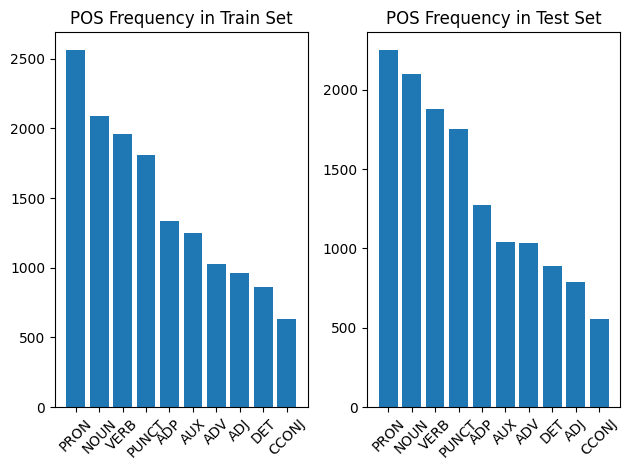

In [ ]:
# POS frequency train

y_train = [count for tag, count in most_common_POS_train[0:10]]
x_train = [tag for tag, count in most_common_POS_train[0:10]]

y_test = [count for tag, count in most_common_POS_test[0:10]] # !!! alle test-data-werte stimmen noch nicht !!!
x_test = [tag for tag, count in most_common_POS_test[0:10]] # !!! alle test-data-werte stimmen noch nicht !!!

plt.subplot(121)  #sublot(Anzahl Zeilen Anzahl Spalten Bild Nummer)
plt.bar(x_train, y_train)
plt.title("POS Frequency in Train Set")
plt.tight_layout()
plt.xticks(rotation=45)

plt.subplot(122)
plt.bar(x_test, y_test)
plt.title("POS Frequency in Test Set")
plt.tight_layout()
plt.xticks(rotation=45)

In [ ]:
# Syntactic Structure (frequent POS sequences)
...

NameError: name 'sentim_label_test' is not defined

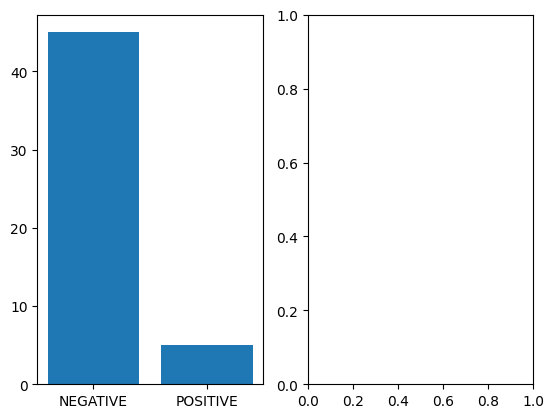

In [ ]:
# Sentiment Labels

plt.subplot(121)
l = Counter(sentim_label_train)
plt.bar(l.keys(), l.values())

plt.subplot(122)
l = Counter(sentim_label_test) # !!! test-set-werte fixen!!!
plt.bar(l.keys(), l.values())

<BarContainer object of 2 artists>

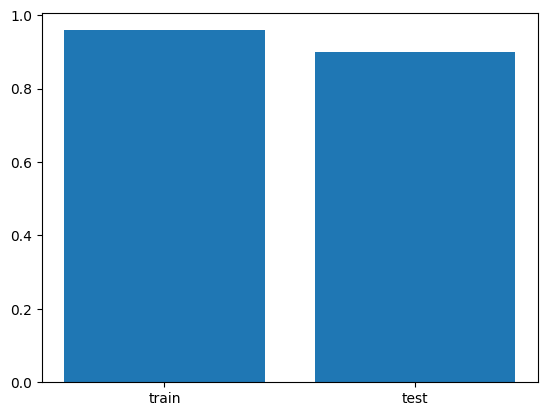

In [ ]:
# Sentiment
x = ['train', 'test']
y = [avg_sentim_train, avg_sentim_test] # !!!! avg_test not finished yet

plt.bar(x, y)

## 5 Predictictions matching

Generate predictions for the portion of the test split where the main statistics match the training statistics from the model (50 examples sufficient).

Annotate your intuitive quality judgement of the outputs.

Get reward model predictions for the outputs.

In [ ]:
## ...

## 6 Predictions mismatching

Generate predictions for the portion of the test split where the main statistics MISmatch the training statistics from the model (50 examples sufficient).

Annotate your intuitive quality judgement of the outputs.

Get reward model predictions for the outputs.

In [ ]:
## ...

## 7 Comparison

Compare the rewards and your own judgements.

Does the model perform worse on the portion of the test split which is OOD relative to the train split?

In [ ]:
## ...